# Méthodologie : sélectionner le nombre k de voisins dans un k-NN dans le cadre d'un protocole de validation croisée

L'algorithme KNN (k-nearest neighbors) est un algorithme simple d'apprentissage automatique supervisé qui peut être utilisé pour résoudre les problèmes de classification et de régression. Il est facile à mettre en œuvre et à comprendre, mais présente l'inconvénient majeur de devenir nettement plus lent à mesure que la taille des données utilisées augmente.

KNN fonctionne en trouvant les distances entre une requête et tous les exemples dans les données, en sélectionnant le nombre spécifié d'exemples (K) les plus proches de la requête, puis en votant pour l'étiquette la plus fréquente (dans le cas de la classification) ou en faisant la moyenne des étiquettes (dans le cas de la régression).

## Importation des datas & librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Nous allons travailler avec un jeu de données qui contient des informations physico-chimiques de vins portugais (vinho verde), ainsi que leur qualité   issu des archives UCI : *https://archive.ics.uci.edu/ml/datasets/Wine+Quality*

In [2]:
data = pd.read_csv(r"C:\Users\ynore\Desktop\Evaluer les perf d'un algo\winequality-white.csv", sep =";")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Nous allons extraire deux arrays de ces données, un qui contient les points et l’autre qui contient les étiquettes (quality) :  

In [4]:
X = data[data.columns[:-1]].values
y = data['quality'].values

Affichons maintenant un histogramme pour voir la répartition des individus dans les variables :

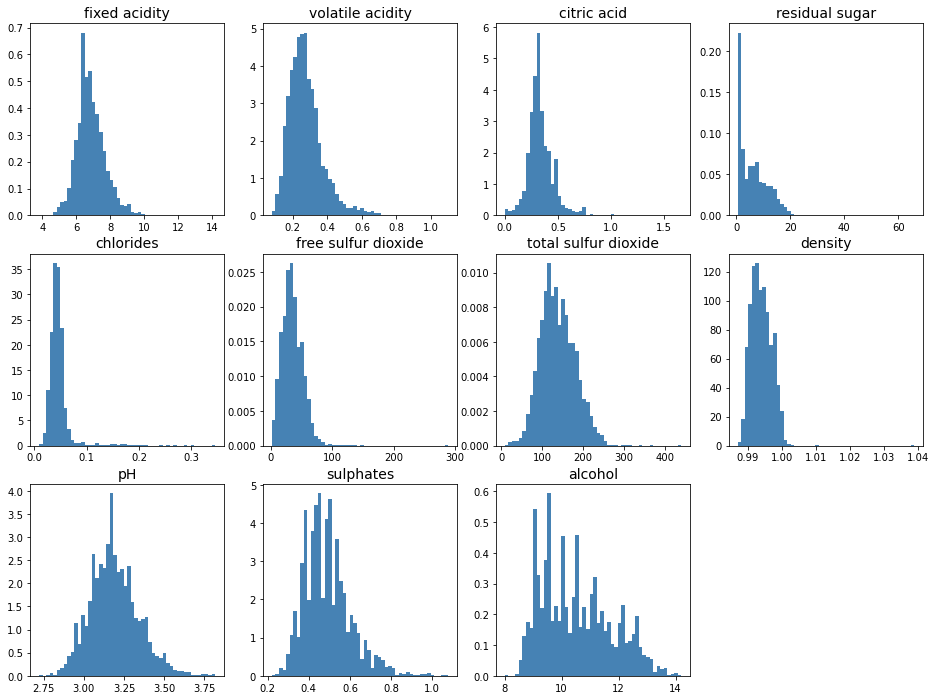

In [5]:
fig = plt.figure(figsize=(16, 12))

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première. Si l'échelle des variables n'est pas la même, le modèle pourrait être biaisé en faveur des variables ayant une magnitude plus élevée.

## Sélection du modèle

Transformons d'abord ce problème en un problème de classification : bon vins (quality > 6 ) vs mauvais vins (quality < 6):

In [6]:
y_class = np.where(y<6, 0, 1)

Puis séparons nos données en un jeu d'entraînement et un jeu test (30% des données) :

In [7]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

On peut maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [8]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

Si on visualise de nouveau les données (maintenant standardisées) : 

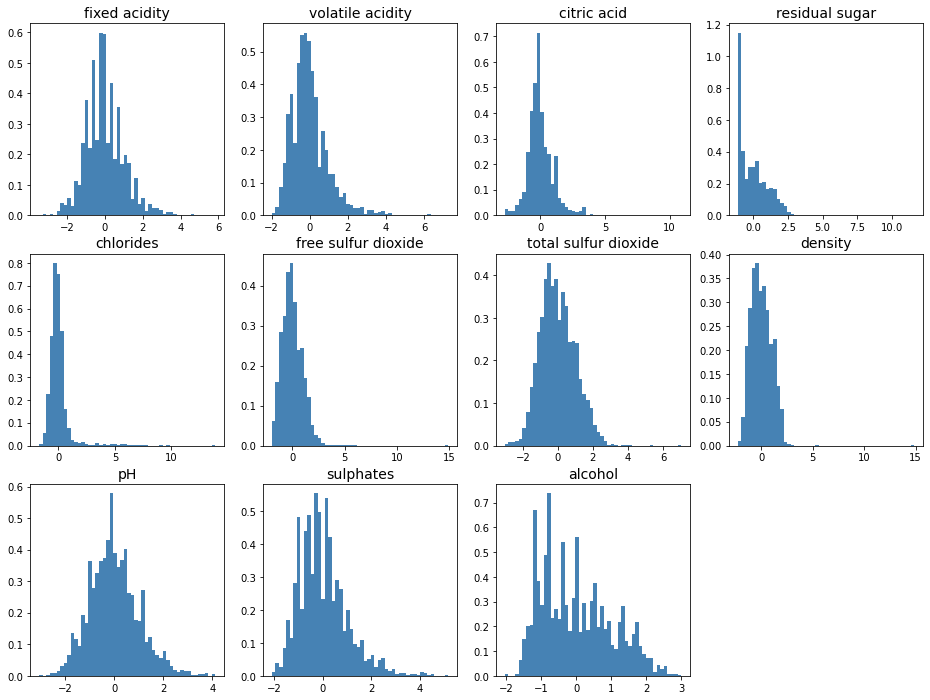

In [9]:
fig = plt.figure(figsize=(16, 12))

for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On constate qu'elles ont bien toutes le même ordre de grandeur.

Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [10]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]},
             scoring='accuracy')

In [11]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances de chaque hyperparamètre
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}
Résultats de la validation croisée :
accuracy = 0.755 (+/-0.028) for {'n_neighbors': 3}
accuracy = 0.759 (+/-0.030) for {'n_neighbors': 5}
accuracy = 0.758 (+/-0.033) for {'n_neighbors': 7}
accuracy = 0.756 (+/-0.030) for {'n_neighbors': 9}
accuracy = 0.762 (+/-0.020) for {'n_neighbors': 11}
accuracy = 0.762 (+/-0.026) for {'n_neighbors': 13}
accuracy = 0.763 (+/-0.026) for {'n_neighbors': 15}


La meilleure performance est obtenue avec 5 voisins (0.761). Cependant, les autres performances ne sont pas très loin et il est possible que le meilleur hyperparamètre soit différent lorsqu'on relance l'algorithme.  

Nous pouvons maintenant regarder la performance sur le jeu de test :

In [12]:
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


Sur le jeu de test : 0.765


On obtient ici une performance de 0.77 ce qui est meilleur qu'à l'entraînement !

# Courbe ROC (Receiver operating characteristic) 

Bien que le but d'un algorithme de classification soit de faire des prédictions binaires, un grand nombre d'algorithmes retournent un nombre réel. Plus cette valeur est élevée, plus le point est susceptible d'être positif.

Par exemple, l’algorithme des k plus proches voisins (kNN) pourrait retourner non pas la classe majoritaire parmi celles de k plus proches voisins du point, mais la proportion d’exemples positifs parmi ces voisins. Dans ce cas, pour retourner une prédiction binaire, il faut seuiller : si le score retourné est supérieur au seuil, alors on prédit positif ; s’il est inférieur, on prédit négatif. 

Pour définir ce seuil nous allons donc construire une courbe pour montrer comment la sensibilité évolue en fonction de la spécificité : on appelle cette courbe la courbe de ROC.

Text(0, 0.5, 'Sensibilite')

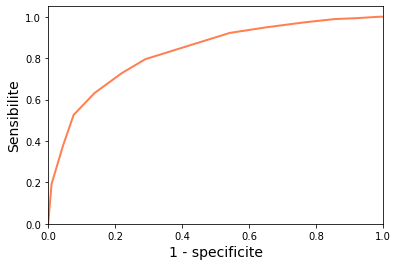

In [13]:
# Courbe de ROC :

y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

On peut résumer la courbe ROC par "l'aire sous la courbe", aussi dénotée AUROC pour « Area Under the ROC », qui permet plus aisément de comparer plusieurs modèles : 

In [14]:
# calcul de l'air :

print(metrics.auc(fpr, tpr))

0.8300536082474227


Maintenant, pour délimiter un seuil, on fixe soit la spécificité, soit la sensibilité que l'on désire, et on cherche le seuil correspondant. Imaginons que l’algorithme doit être capable de détecter efficacement les vins de mauvaise qualité. On veut alors limiter le nombre de faux négatifs, pour limiter le nombre de rejets infondés. Fixons-nous un taux de faux négatifs tolérable (la proportion de positifs incorrectement prédits négatifs) de 5%. Cela équivaut à une sensibilité de 0.95

In [15]:
# indice du premier seuil pour lequel la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))


Sensibilité : 0.97
Spécificité : 0.24
Seuil : 0.33


# Comparer un modèle k-NN à des approches naïves :

Reprenons notre jeu de données standardisées et séparé en jeux test/entraînement. Comme les étiquettes sont des nombres entiers, nous pouvons traiter la prédiction de la note de chaque vin à partir de ses caractéristiques physico-chimiques comme un problème de régression.

In [23]:
X = data[data.columns[:-1]].values
y = data['quality'].values

# séparation des données
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3 ) # 30% des données dans le jeu de test

# Standardisons les données :
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

Entraînons un kNN avec k=11 sur ces données :

In [25]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train_std, y_train)

KNeighborsRegressor(n_neighbors=11)

In [26]:
# Et appliquons le pour prédire les étiquettes de notre jeu de test :
y_pred = knn.predict(X_test_std)

In [27]:
# Calculons la RMSE correspondante :
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y_test, y_pred) )))


RMSE : 0.67


J'obtiens une RMSE de 0.67. Nos étiquettes étant des nombres entiers, nous faisons en moyenne une erreur inférieure à la plus petite différence possible entre deux notes.
Nous pouvons visualiser les résultats sur un graphique, en représentant en abscisse les vraies valeurs des étiquettes, et en ordonnée les valeurs prédites.


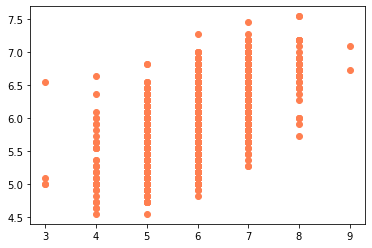

In [28]:
plt.scatter(y_test, y_pred, color='coral')

Comme nos étiquettes prennent des valeurs entières entre 3 et 9, nous avons beaucoup de points superposés aux mêmes coordonnées. Pour mieux visualiser les données, nous pouvons utiliser comme marqueurs des cercles dont la taille est proportionnelle au nombre de points qui sont présents à ces coordonnée :

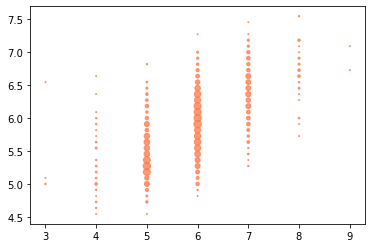

In [29]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)

La taille des marqueurs est proportionnelle à celle du nombre de points à ces coordonnées. On note ainsi une accumulation de prédictions correctes sur la diagonale. Néanmoins le modèle n'est pas très précis dans ses prédictions.

Pour mieux comprendre notre modèle, comparons-le à une première approche naïve, qui consiste à prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes du jeu de données d'entraînement.

In [31]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)

# Calculons la RMSE correspondante :
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_random))))

RMSE : 1.92


J'obtiens une RMSE de 1.92, ce qui est bien supérieur à la RMSE obtenue par notre modèle kNN. Notre modèle a ainsi réussi à bien mieux apprendre qu'un modèle aléatoire.

Cependant, beaucoup de nos vins ont une note de 6, et beaucoup de nos prédictions sont autour de cette valeur. Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement :


In [32]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)) ))


RMSE : 0.87


J'obtiens une RMSE de 0.87, qui est supérieure à celle de 0.67 obtenue par le kNN. Le kNN a donc appris plus que la moyenne des étiquettes…